# Importing Libraries:

In [63]:
!pip3 install fuzzywuzzy
!pip3 install distance
!pip3 install WordCloud


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fuzzywuzzy import fuzz
import distance
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from gensim.models import Word2Vec
import math
from sklearn.metrics import accuracy_score, log_loss 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
p1 = '/content/drive/MyDrive/dataset/train_quora.csv'
data = pd.read_csv(p1)
print(data.shape)
data.head(4)

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0


In [67]:
# Getting 70,000 random rows from a total of 404290 rows:

data_ = data.sample(n = 70000)
data_.head(4)

,id,qid1,qid2,question1,question2,is_duplicate
75944,75944,23357,129887,What should I do to stay motivated and happy?,How do I become and stay motivated forever?,0
160988,160988,250971,250972,Which books are a must read for an English lit...,What are the must-read books for a literature ...,0
189364,189364,288094,288095,What is the best website for electrical engine...,What are the best websites for an electrical e...,0
359826,359826,326973,489520,How do I deal with annoying friends?,How do I deal with annoying children?,0


In [123]:
# Example of non-similar questions:

print('Following is the example for NON-SIMILAR questions')
print('*'*100)
print(data_['question1'].values[0])
print('*'*100)
print(data_['question2'].values[0])

Following is the example for NON-SIMILAR questions
****************************************************************************************************
What should I do to stay motivated and happy?
****************************************************************************************************
How do I become and stay motivated forever?


In [125]:
# Example of similar questions:

print('Following is the example for SIMILAR questions')
print('*'*100)
print(data_['question1'].values[7])
print('*'*100)
print(data_['question2'].values[7])

Following is the example for SIMILAR questions
****************************************************************************************************
Which smartphone is superior between the iPhone 7 and the Samsung Galaxy S7?
****************************************************************************************************
Should I buy an iPhone 7 or Samsung S7? Why?


In [68]:
# Storing two questions in seperate variable:

q1 = data_.iloc[:,3].values
q2 = data_.iloc[:,4].values
y = data_.iloc[:,-1].values # class label

In [69]:
labels = data_['is_duplicate'].value_counts()
labels

0    44115
1    25885
Name: is_duplicate, dtype: int64

# Distribution of class label: 0 = Not Duplicate, 1 = Duplicate


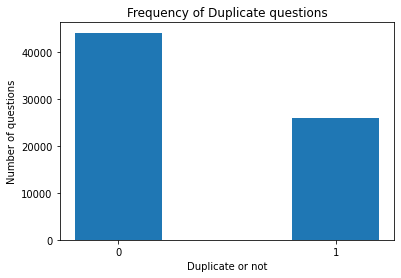

In [70]:
x_axis = [str(0),str(1)]
y_axis = [labels[0],labels[1]]

plt.bar(x_axis,y_axis,width = 0.4,)
plt.xlabel('Duplicate or not')
plt.ylabel('Number of questions')
plt.title('Frequency of Duplicate questions')
plt.show()

- We see that this is a case of imbalanced dataset. 
- Number of non-duplicate questions are more than duplicate questions.

In [71]:
# Percentage of similar questions:

similar = ((labels[1])/(labels[0] + labels[1]))*100
not_similar = ((labels[0])/(labels[0] + labels[1]))*100
print('Percentage of Similar question pairs in dataset is: {}%'.format(similar))
print('Percentage of Not Similar questions in dataset is: {}%'.format(not_similar))


Percentage of Similar question pairs in dataset is: 36.97857142857143%
Percentage of Not Similar questions in dataset is: 63.02142857142857%


# Checking null values:

In [72]:
null_value = data_[data_.isnull().any(1)]
print(null_value)
print('*'*75)
data_ = data_.fillna('')
nan_rows = data_[data_.isnull().any(1)]
print (nan_rows)

# .any(1) this returns the instance where the dataframe has null values

            id    qid1    qid2                         question1 question2  \
201841  201841  303951  174364  How can I create an Android app?       NaN   

        is_duplicate  
201841             0  
***************************************************************************
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


- There is only one question with missing data, we replace the (NaN) with an empty string ('  ')

# Genreal idea about data:

In [73]:
# Here, we see which questions are repeated multiple number of times.
# We get to know about these questions through the "question id" (qid)

ques = pd.Series(data_['qid1'].tolist() + data_['qid2'].tolist())
unique_ques = len(np.unique(ques))
repeat = np.sum(ques.value_counts() > 1)
max_ques = max(ques.value_counts())
values = ques.value_counts()

idx = ques.value_counts().index.tolist()[0] # To get the qid value for question that repeats maximum number of times

maxi = data_.loc[(data_['qid1'] == idx)]
maxi2 = maxi[maxi.columns[[3]]]

print('Question ID and their number of occurences')
print(values[:5])


Question ID and their number of occurences
2559     27
17978    19
28764    18
4044     18
14376    17
dtype: int64


In [74]:
print('Total number of unique questions are: ',unique_ques)
print('*'*75)
print('{}% of the unique questions repeat themselves'.format(round((repeat/unique_ques)*100,2)))
print('*'*75)
print('The following question is repeated {} times'.format(max_ques))
(maxi2)

Total number of unique questions are:  120910
***************************************************************************
9.85% of the unique questions repeat themselves
***************************************************************************
The following question is repeated 27 times


,question1
82016,What are the best ways to lose weight?
277652,What are the best ways to lose weight?
345086,What are the best ways to lose weight?
228265,What are the best ways to lose weight?
14712,What are the best ways to lose weight?
253672,What are the best ways to lose weight?


# Data Cleaning:

In [75]:
# not removing stop-words yet: 

lemma = WordNetLemmatizer()
import nltk
nltk.download('wordnet')

import re
def clean(text):
    '''
    This function gets rid of all punctuation marks, special characters
    and expands the contracted words and returns words in its lemma form
    
    '''
    sent = text.lower().strip() # Done for whole sentence
    sent = re.sub('[^a-zA-Z]',' ',text) # Done for whole sentence
    sent = sent.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("doesn't", "does not")
    sent = sent.split()
    final = [lemma.lemmatize(word) for word in sent]
    final_sent =  ' '.join(final)
    return final_sent

# The strip() method removes any leading (spaces at the beginning) and trailing (spaces at the end) characters

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [76]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [77]:
q1_clean = [] # This stores all the question1 text which has been cleaned 
for z in range(len(q1)):
    res = clean(str(q1[z]))
    q1_clean.append(res)

In [78]:
q2_clean = [] # This stores all the question2 text which has been cleaned 
for v in range(len(q2)):
    res2 = clean(str(q2[v]))
    q2_clean.append(res2)

# Wordcloud:

In [79]:
duplicate = data_[data_['is_duplicate'] == 1] # Storing data having class label as 1 
not_duplicate = data_[data_['is_duplicate'] == 0] # Storing data having class label as 0 

similar = np.dstack([duplicate["question1"],duplicate["question2"]]).flatten()
no_similar = np.dstack([not_duplicate["question1"], not_duplicate["question2"]]).flatten()

In [80]:
# An example of using np.dstack and flatten() operation:
gfg1 = np.array([1, 2, 3])
gfg2 = np.array([4, 5, 6])

print(np.dstack((gfg1, gfg2)))
print(np.dstack((gfg1, gfg2)).flatten())


[[[1 4]
  [2 5]
  [3 6]]]
[1 4 2 5 3 6]


In [81]:
print((similar)[:4])

['Which smartphone is superior between the iPhone 7 and the Samsung Galaxy S7?'
 'Should I buy an iPhone 7 or Samsung S7? Why?'
 'Which are the best places to visit in Estonia?'
 'Which are the best places to visit in Estonia? Www.krazybutterfly.com']


In [82]:
print(no_similar[:4])

['What should I do to stay motivated and happy?'
 'How do I become and stay motivated forever?'
 'Which books are a must read for an English literature student?'
 'What are the must-read books for a literature student?']


In [83]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Word Cloud for Duplicate question


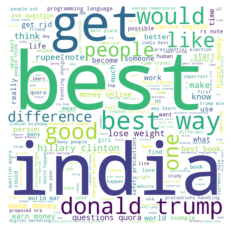

In [84]:
# Word Cloud for Duplicate question:
stop_words = set(stopwords.words("english")) # to remove the stopwords

duplicate_words = ''
for j in (similar): # This loop extracts words from sentences given to it as input
    c = (str(j).split())
    for v in c:
        b = v.lower()
        duplicate_words += "".join(b)+" "
            
wc_q = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10)
wc_q.generate(duplicate_words)
print('Word Cloud for Duplicate question')
plt.imshow(wc_q, interpolation='bilinear')
plt.axis("off")
plt.show()
    

- We see that duplicate questions have these words occur frequently (Difference,Good,Donald Trump,Weight)

Word Cloud for Non Duplicate question


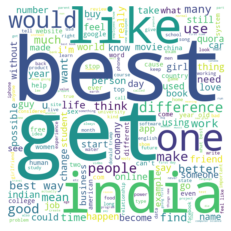

In [85]:
# Word Cloud for Non-Duplicate question:

not_duplicate_words = ''
for p in (no_similar):
    d = (str(p).split())
    for n in d:
        s = n.lower()
        not_duplicate_words += "".join(s)+" "
            
wc_q_ = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10)
wc_q_.generate(not_duplicate_words)
print('Word Cloud for Non Duplicate question')
plt.imshow(wc_q_, interpolation='bilinear')
plt.axis("off")
plt.show()

- ***Although we see that words like (Best,India,get,people) occur frequently in both duplicate and non-duplicate questions.***

#  Feature Extraction:

In [86]:
# Length of sentence
q1_len = [len(i.split()) for i in q1_clean]
q2_len = [len(j.split()) for j in q2_clean]

# Common words between two sentences
def comm(k):
    w1 = set(map(lambda word: word.lower().strip(), q1_clean[k].split(" "))) 
    w2 = set(map(lambda word: word.lower().strip(), q2_clean[k].split(" ")))    
    return len(w1&w2)
common = [comm(r) for r in range(len(q1_clean))] # storing the number of common words

# Word_share: (common_word_count/total number of words)

total = [a+b for a,b in zip(q1_len,q2_len)]
word_share = [round((c/d),3) for c,d in zip(common,total)] 

# cwc_min & cwc_max: (Ratio of common_word_count to min & max length of word count of Q1 and Q2)

min_len = [min(u,t) for u,t in zip(q1_len,q2_len)] # this returns length of either Q1 or Q2, whichever has minimum one.
max_len = [max(u_,t_) for u_,t_ in zip(q1_len,q2_len)] # this returns length of either Q1 or Q2, whichever has maximum one.

cwc_min = [round((e/f),3) if f!=0 else 0 for e,f in zip(common,min_len)] #if min_len =0, appending zero to avoid zero divison error
cwc_max = [round((e/f),3) for e,f in zip(common,max_len)]

# first word equal or not:

first_word = []
for g in range(len(q1_clean)):
    if len(q1_clean[g].split()) != 0 and len(q2_clean[g].split()) != 0: # handling the condition when length of question = 0
        s3 = q1_clean[g].split()[0]
        s4 = q2_clean[g].split()[0]
    
        if s3 == s4:
            first_word.append(1) # if first word of Q1 & Q2 is same, append 1
        else:
            first_word.append(0) # if first word of Q1 & Q2 is NOT same, append 0
    else:
        first_word.append(0)
        

# last word equal or not:
last_word = []
for g in range(len(q1_clean)):
    if len(q1_clean[g].split()) != 0 and len(q2_clean[g].split()) != 0:
        s3 = q1_clean[g].split()[-1]
        s4 = q2_clean[g].split()[-1]
        if s3 == s4: 
            last_word.append(1) # if last word of Q1 & Q2 is same, append 1. Else 0
        else:
            last_word.append(0)
    else:
        last_word.append(0)
        
len_diff = [abs(t1-t2) for t1,t2 in zip(q1_len,q2_len)] #this returns absolute difference between number of words in Q1 & Q2
avg_len = [(t1+t2)/2 for t1,t2 in zip(q1_len,q2_len)] #this returns average number of words in Q1 & Q2

In [87]:
# Adding these new extracted features to the dataframe

data_['q1_length'] = q1_len
data_['q2_length'] = q2_len
data_['common words'] = common
data_['word share'] = word_share
data_['cwc_min'] = cwc_min
data_['cwc_max'] = cwc_max
data_['first word equal'] = first_word
data_['last word equal'] = last_word
data_['difference in no.of words'] = len_diff
data_['avg length of words'] = avg_len

In [88]:
(data_.head())

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,common words,word share,cwc_min,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words
75944,75944,23357,129887,What should I do to stay motivated and happy?,How do I become and stay motivated forever?,0,9,8,5,0.294,0.625,0.556,0,0,1,8.5
160988,160988,250971,250972,Which books are a must read for an English lit...,What are the must-read books for a literature ...,0,11,10,8,0.381,0.800,0.727,0,1,1,10.5
189364,189364,288094,288095,What is the best website for electrical engine...,What are the best websites for an electrical e...,0,9,9,6,0.333,0.667,0.667,1,0,0,9.0
359826,359826,326973,489520,How do I deal with annoying friends?,How do I deal with annoying children?,0,7,7,6,0.429,0.857,0.857,1,0,0,7.0
340596,340596,107610,468348,What kind of sword do I have?,What kind of sword is Excalibur depicted as?,0,7,8,4,0.267,0.571,0.500,1,0,1,7.5


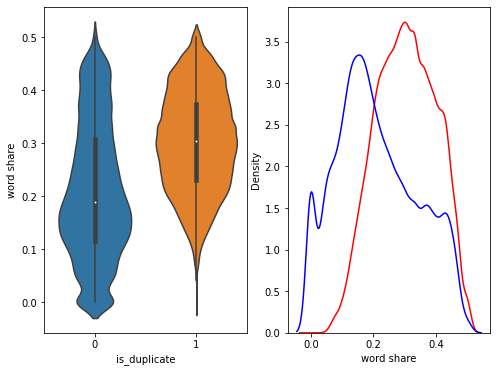

In [89]:
# Data visualization for "Word Share":

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word share', data = data_[0:])

plt.subplot(1,2,2)
sns.kdeplot(data_[data_['is_duplicate'] == 1.0]['word share'][0:] , label = "1", color = 'red')
sns.kdeplot(data_[data_['is_duplicate'] == 0.0]['word share'][0:] , label = "0" , color = 'blue' )
plt.show()

- There is significant overlap when word_share is used as feature to classify question pairs as duplicate or not. So, this feature doesn't help much.

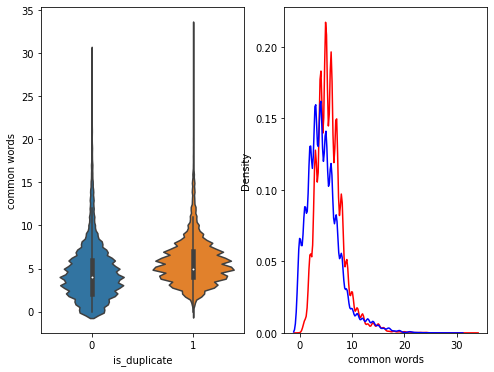

In [90]:
# Data visualization for "Common words":

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common words', data = data_[0:])

plt.subplot(1,2,2)
sns.kdeplot(data_[data_['is_duplicate'] == 1.0]['common words'][0:] , label = "1", color = 'red')
sns.kdeplot(data_[data_['is_duplicate'] == 0.0]['common words'][0:] , label = "0" , color = 'blue' )
plt.show()

- Highly overlapping distibution is observed. Hence, this feature also doesn't help much for classifying labels as 0 or 1

# Advanced Feature Extraction: (Fuzzwuzzy)

In [91]:
# To get longest substring ratio

def lsubstring_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b)) # This returns the length of longest common substring
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1) # This gives us the LCS ratio

# partial ratio:
partial = [fuzz.partial_ratio(k.split(),l.split()) for k,l in zip(q1_clean,q2_clean)]

# token sort ratio:
token_sort = [fuzz.token_sort_ratio(k.split(),l.split()) for k,l in zip(q1_clean,q2_clean)]

# token set ratio:
token_set = [fuzz.token_set_ratio(k.split(),l.split()) for k,l in zip(q1_clean,q2_clean)]

# WRatio:
wratio = [fuzz.WRatio(k.split(),l.split()) for k,l in zip(q1_clean,q2_clean)]

# LCSubstring ratio
lcs = [lsubstring_ratio(k,l) for k,l in zip(q1_clean,q2_clean)]


In [92]:
# Adding these new advanced features to the dataframe:

data_["token_set_ratio"] = token_set
data_["token_sort_ratio"] = token_sort
data_["fuzz_WRatio"] = wratio
data_["fuzz_partial_ratio"] = partial
data_["longest_substr_ratio"]  = lcs

data_.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,common words,word share,...,cwc_max,first word equal,last word equal,difference in no.of words,avg length of words,token_set_ratio,token_sort_ratio,fuzz_WRatio,fuzz_partial_ratio,longest_substr_ratio
75944,75944,23357,129887,What should I do to stay motivated and happy?,How do I become and stay motivated forever?,0,9,8,5,0.294,...,0.556,0,0,1,8.5,71,58,67,63,0.372093
160988,160988,250971,250972,Which books are a must read for an English lit...,What are the must-read books for a literature ...,0,11,10,8,0.381,...,0.727,0,1,1,10.5,91,82,86,80,0.358491
189364,189364,288094,288095,What is the best website for electrical engine...,What are the best websites for an electrical e...,0,9,9,6,0.333,...,0.667,1,0,0,9.0,84,84,86,88,0.415094
359826,359826,326973,489520,How do I deal with annoying friends?,How do I deal with annoying children?,0,7,7,6,0.429,...,0.857,1,0,0,7.0,90,81,93,93,0.823529
340596,340596,107610,468348,What kind of sword do I have?,What kind of sword is Excalibur depicted as?,0,7,8,4,0.267,...,0.500,1,0,1,7.5,78,69,75,78,0.655172


# Data Visualization of Advanced Features:

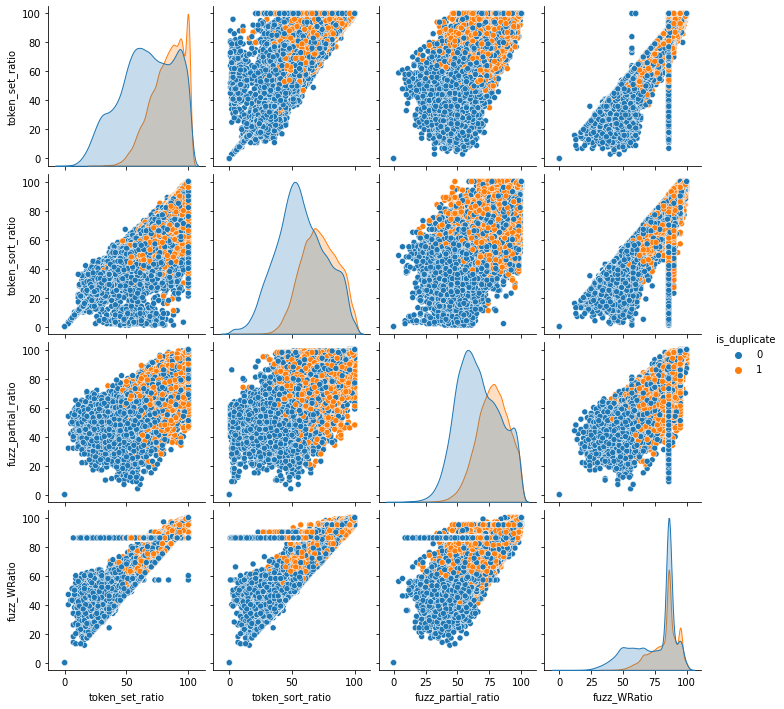

In [93]:
# Pair plot of some of the advanced features:

n = len(data_)
sns.pairplot(data_[['token_set_ratio', 'token_sort_ratio', 'fuzz_partial_ratio', 'fuzz_WRatio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['token_set_ratio', 'token_sort_ratio', 'fuzz_partial_ratio', 'fuzz_WRatio'])
plt.show()

# vars:list of variable names
# Variables within data to use, otherwise use every column with a numeric datatype.

- From above combination of features we see that **token sort/set ratio** & **fuzz_partial_ratio** can give us fairly good results for the classification task.

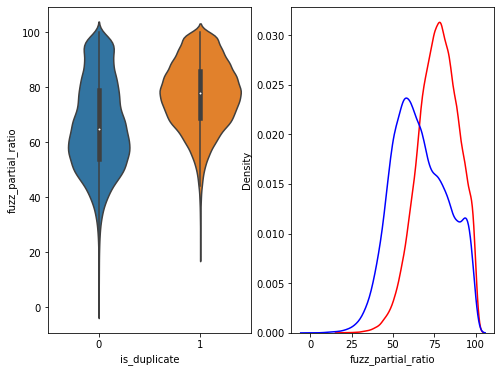

In [94]:
# Distribution of the fuzz_partial_ratio:

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = data_[0:])

plt.subplot(1,2,2)
sns.kdeplot(data_[data_['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red',)
sns.kdeplot(data_[data_['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue')
plt.show()

- Fuzz partial ratio as a feature has major overlap for values between 45 - 100.

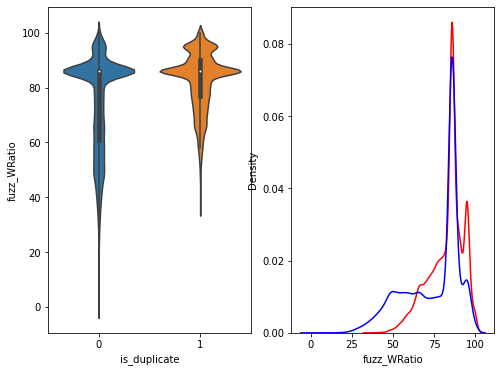

In [95]:
# Distribution of the WRatio:

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_WRatio', data = data_[0:])

plt.subplot(1,2,2)
sns.kdeplot(data_[data_['is_duplicate'] == 1.0]['fuzz_WRatio'][0:] , label = "1", color = 'red',)
sns.kdeplot(data_[data_['is_duplicate'] == 0.0]['fuzz_WRatio'][0:] , label = "0" , color = 'blue')
plt.show()

- For WRatio <45, class label 0 can be easily classified.

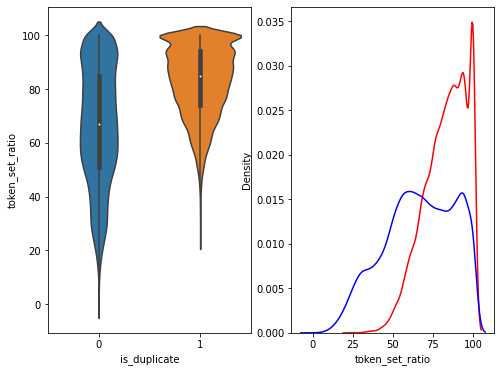

In [96]:
# Distribution of the Token Set ratio:

plt.figure(figsize=(8, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = data_[0:])

plt.subplot(1,2,2)
sns.kdeplot(data_[data_['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red',)
sns.kdeplot(data_[data_['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue')
plt.show()

- Token set ratio as a feature works fairly well as seen from kdeplot.

# Data Preprocessing:

In [97]:
# Removing stop words:
all_stopwords = stopwords.words('english')

# Removing the following words from list containing stopwords
all_stopwords.remove('not')
all_stopwords.remove('but')
all_stopwords.remove('because')
all_stopwords.remove('against')
all_stopwords.remove('between')
all_stopwords.remove('up')
all_stopwords.remove('down')
all_stopwords.remove('in')
all_stopwords.remove('out')
all_stopwords.remove('once')
all_stopwords.remove('before')
all_stopwords.remove('after')
all_stopwords.remove('few')
all_stopwords.remove('more')
all_stopwords.remove('most')
all_stopwords.remove('no')
all_stopwords.remove('nor')
all_stopwords.remove('same')
all_stopwords.remove('some')

def remove_stopwords(texts):
    '''
    This function removes stopwords from the sentences
    
    '''
    sentence = texts.lower().strip()
    sentence = sentence.split()
    final1 = [word1 for word1 in sentence if not word1 in set(all_stopwords)]
    final1_ = ' '.join(final1)
    return final1_

q1_clean1 = [] # this contains question1 without any stopwords.
for z in range(len(q1_clean)):
    res = remove_stopwords(str(q1_clean[z]))
    q1_clean1.append(res)

q2_clean2 = [] # this contains question2 without any stopwords.
for z in range(len(q1_clean)):
    res2 = remove_stopwords(str(q2_clean[z]))
    q2_clean2.append(res2)  

In [98]:
# TF-IDF Vector:

total_questions = (q1_clean1) + (q2_clean2)
tfidf = TfidfVectorizer(max_features = 1000, min_df=50)
tfidf.fit(total_questions)
q1_vector = tfidf.transform(q1_clean1).toarray()
q2_vector = tfidf.transform(q2_clean2).toarray()

# Creating a dictionary with word as a key, and the idf as a value
# This is done so that we can get TF-IDF values.

tfidf_values = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
print('Shape of tf-idf vector is: ',q1_vector.shape)

Shape of tf-idf vector is:  (70000, 1000)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [99]:
features = tfidf.get_feature_names()
print(features[:25])

['able', 'access', 'account', 'across', 'actor', 'actually', 'ad', 'add', 'address', 'admission', 'advanced', 'advantage', 'advice', 'affect', 'after', 'against', 'age', 'air', 'alcohol', 'algorithm', 'allowed', 'alone', 'already', 'also', 'always']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Creating my own W2V model on the Quora question pair corpus:

In [100]:
# Creating w2v model on question 1:
q1_list = []
for new in (q1_clean1):
    q1_list.append(new.split())
    
w2v_q1=Word2Vec(q1_list,min_count=5,size=200, workers=2) 
w2v_words_q1 = list(w2v_q1.wv.vocab)
print("sample words ", w2v_words_q1[0:50])

# size = 200---> each word will be represented by a 200 dimensional vector.
# min_count = 5---> only those words are considered which atleast ocuur (5 times) in the corpus.

sample words  ['stay', 'motivated', 'happy', 'book', 'must', 'read', 'english', 'literature', 'student', 'best', 'website', 'electrical', 'engineering', 'job', 'deal', 'annoying', 'friend', 'kind', 'sword', 'would', 'consequence', 'nuclear', 'bomb', 'wa', 'dropped', 'city', 'ar', 'declared', 'capital', 'anonymous', 'country', 'ultimate', 'goal', 'smartphone', 'superior', 'between', 'iphone', 'samsung', 'galaxy', 'cause', 'place', 'visit', 'in', 'much', 'money', 'earn', 'tumblr', 'some', 'idea', 'get']


In [101]:
# Creating w2v model on question 2:
q2_list = []
for new2 in (q2_clean2):
    q2_list.append(new2.split())
    
w2v_q2 = Word2Vec(q2_list,min_count=5,size=200, workers=2) 
w2v_words_q2 = list(w2v_q2.wv.vocab)

In [102]:
# Getting TF-IDF*W2V values for question 1 :

tfidf_w2v_q1 = [] # the tfidf-w2v for each question1 is stored in this list

for sent1 in tqdm(q1_list): # for each question1
    sent_vec1 = np.zeros(200) 
    tfidf_sum1 =0
    for word1 in sent1: # for each word in question1
        if word1 in w2v_words_q1 and word1 in features:
            vec1 = w2v_q1.wv[word1] # w2v vector for the word
            tf_idf_q1 = tfidf_values[word1]*(sent1.count(word1)/len(sent1)) # idf * tf = tfidf
            sent_vec1 += (vec1 * tf_idf_q1) # w2v * tfidf
            tfidf_sum1 += tf_idf_q1 # summation of tfidf
    if tfidf_sum1 != 0: # handling boundary condition
        sent_vec1 = sent_vec1/tfidf_sum1
    tfidf_w2v_q1.append(sent_vec1)

tfidf_w2v_q1_list = list(tfidf_w2v_q1)

100%|██████████| 70000/70000 [00:26<00:00, 2687.75it/s]


In [103]:
# Getting TF-IDF*W2V values for question 2 :

tfidf_w2v_q2 = [] # the tfidf-w2v for each question 2 is stored in this list

for sent2 in tqdm(q2_list): # for each question2
    sent_vec2 = np.zeros(200) 
    tfidf_sum2 =0
    for word2 in sent2: # for each word in question2
        if word2 in w2v_words_q2 and word2 in features:
            vec2 = w2v_q2.wv[word2] 
            tf_idf_q2 = tfidf_values[word2]*(sent2.count(word2)/len(sent2)) 
            sent_vec2 += (vec2 * tf_idf_q2) 
            tfidf_sum2 += tf_idf_q2 
    if tfidf_sum2 != 0:
        sent_vec2 = sent_vec2/tfidf_sum2
    tfidf_w2v_q2.append(sent_vec2)

tfidf_w2v_q2_list = list(tfidf_w2v_q2)
   

100%|██████████| 70000/70000 [00:24<00:00, 2904.67it/s]


In [104]:
print('The dimensions of TF_IDF_W2V is:',len(tfidf_w2v_q2[0]))

The dimensions of TF_IDF_W2V is: 200


In [105]:
# Dropping the features which won't be required in Modeling

new_data = data_.drop(['qid1','qid2','question1','question2'], axis = 1)
print(new_data.shape)

(70000, 17)


In [106]:
n1 = pd.DataFrame(tfidf_w2v_q1_list,index = new_data.index) # Storing the q1 vector here
n2 = pd.DataFrame(tfidf_w2v_q2_list,index = new_data.index) # Storing the q2 vector here
n1['id']=new_data['id']
n2['id']=new_data['id']

In [107]:
# Merging all the dataframes:

n3 = n1.merge(n2,on = 'id',how ='left')
final_data = new_data.merge(n3,on = 'id',how ='left')
print('Final dimensions of the data:',final_data.shape)
final_data

Final dimensions of the data: (70000, 417)


,id,is_duplicate,q1_length,q2_length,common words,word share,cwc_min,cwc_max,first word equal,last word equal,...,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y
0,75944,0,9,8,5,0.294,0.625,0.556,0,0,...,0.032995,0.228315,-0.259704,-0.259889,0.126695,0.025182,0.041192,-0.183892,0.352583,-0.425512
1,160988,0,11,10,8,0.381,0.800,0.727,0,1,...,0.179594,0.091633,-0.351386,-0.346122,0.266504,-0.154237,-0.159527,-0.077639,0.291618,-0.091917
2,189364,0,9,9,6,0.333,0.667,0.667,1,0,...,0.285303,0.289533,-0.345133,-0.620649,-0.103018,0.040709,-0.044578,-0.038347,0.436384,-0.174625
3,359826,0,7,7,6,0.429,0.857,0.857,1,0,...,-0.380749,0.200667,-0.343347,-0.147434,-0.120787,-0.203450,-0.192400,-0.230113,0.241218,-0.126763
4,340596,0,7,8,4,0.267,0.571,0.500,1,0,...,-0.283322,0.300059,-0.261567,-0.256757,-0.193009,-0.085889,-0.160738,-0.138840,0.191011,-0.020006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,377677,0,13,15,8,0.286,0.615,0.533,1,0,...,0.137229,0.271406,-0.244352,-0.466757,-0.147907,-0.029915,0.136456,-0.187442,0.403296,-0.382727
69996,196388,0,14,5,5,0.263,1.000,0.357,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
69997,94666,1,11,11,9,0.409,0.818,0.818,1,1,...,-0.417043,-0.126945,-0.192338,-0.155047,-0.065046,-0.120006,-0.106265,-0.297946,0.225496,0.274024
69998,395560,0,7,4,3,0.273,0.750,0.429,1,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Modeling:

In [108]:
x = final_data.drop(['is_duplicate','id'],axis = 1)
y = final_data['is_duplicate']

In [109]:
# Splitting the data into Train,CV and Test Sets:

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,stratify = y,random_state = 0)
x_train1,x_cv,y_train1,y_cv = train_test_split(x_train,y_train,test_size = 0.2,stratify = y_train,random_state = 0)

# stratify helps in fair distribution of class labels for both train and test sets.

In [110]:
print('Train data dimensions:',x_train1.shape)
print('Cross validation data dimensions:',x_cv.shape)
print('Test data dimensions:',x_test.shape)
print('Total train data dimensions:',x_train.shape)

Train data dimensions: (44800, 415)
Cross validation data dimensions: (11200, 415)
Test data dimensions: (14000, 415)
Total train data dimensions: (56000, 415)


# Random Model: (To check the log-loss to beat)

In [111]:
# Since we have binary classification problem, this model randomly generates either 1 or 0 as predicted class label.

predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    random_prob = np.random.rand(1,2)
    predicted_y[i] = ((random_prob/sum(sum(random_prob)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 0.8904828221598522


- Since interpreting the log-loss metric is hard we made this random model to get the log-loss value that we need to beat by using finely tuned models.

# Logistic Regression with Hyperparameter Tuning:

In [112]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparameter for SGD classifier.

log_error_array=[] # this list contains the log-loss obtained with different values of alpha
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train1, y_train1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train1, y_train1)
    predict_y = sig_clf.predict_proba(x_cv) # getting the predictions in form of probabilities to use log_loss as a metric
    
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


best_alpha = np.argmin(log_error_array) # selecting the alpha with minimum log_loss
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train) # now fitting on entire train data
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('*'*100)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('*'*100)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.5219762059825584
For values of alpha =  0.0001 The log loss is: 0.5374072441430167
For values of alpha =  0.001 The log loss is: 0.5411366140875213
For values of alpha =  0.01 The log loss is: 0.5131730907594874
For values of alpha =  0.1 The log loss is: 0.5230032375748743
For values of alpha =  1 The log loss is: 0.558044873673123
For values of alpha =  10 The log loss is: 0.5740677809510552
****************************************************************************************************
For values of best alpha =  0.01 The train log loss is: 0.5215736292357206
****************************************************************************************************
For values of best alpha =  0.01 The test log loss is: 0.5206092202299123


# Random Forest:

In [113]:
classifier = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 0, max_depth = 5)
classifier.fit(x_train, y_train)

sig_clf = CalibratedClassifierCV(classifier, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y_rf_train = sig_clf.predict_proba(x_train)
print('*'*100)

print("The train log loss is:",log_loss(y_train, predict_y_rf_train, labels=classifier.classes_, eps=1e-15))
predict_y_rf_test = sig_clf.predict_proba(x_test)
print('*'*100)
print( "The test log loss is:",log_loss(y_test, predict_y_rf_test, labels=classifier.classes_, eps=1e-15))

****************************************************************************************************
The train log loss is: 0.4919646196167393
****************************************************************************************************
The test log loss is: 0.4997899395613784


In [119]:
import pickle
pickle.dump(classifier,open('quora_clf.pkl','wb'))

## XGBoost:

In [114]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['max_depth'] = 5

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds = 20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# https://xgboost.readthedocs.io/en/stable/python/python_intro.html

[0]	train-logloss:0.690118	valid-logloss:0.690189
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.662794	valid-logloss:0.663486
[20]	train-logloss:0.639755	valid-logloss:0.641176
[30]	train-logloss:0.620134	valid-logloss:0.622202
[40]	train-logloss:0.603199	valid-logloss:0.60587
[50]	train-logloss:0.588647	valid-logloss:0.591887
[60]	train-logloss:0.575938	valid-logloss:0.57975
[70]	train-logloss:0.564689	valid-logloss:0.569011
[80]	train-logloss:0.554628	valid-logloss:0.559549
[90]	train-logloss:0.545684	valid-logloss:0.551137
[100]	train-logloss:0.537647	valid-logloss:0.543708
[110]	train-logloss:0.530571	valid-logloss:0.537102
[120]	train-logloss:0.524198	valid-logloss:0.531237
[130]	train-logloss:0.518432	valid-logloss:0.525862
[140]	train-logloss:0.51334	valid-logloss:0.521241
[150]	train-logloss:0.508669	valid-logloss:0.517012
[160]	train-logloss:0.504269	va

- Train log loss = 0.4678  
- Test log loss = 0.4817